In [2]:
from google.colab import files
uploaded = files.upload()


Saving HRDataset_v14.csv to HRDataset_v14.csv


In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Chargement du fichier
df = pd.read_csv("HRDataset_v14.csv")

# Aperçu des 5 premières lignes
print(df.head())

# Infos générales : types, valeurs manquantes
print(df.info())

# Aperçu statistique des colonnes numériques
print(df.describe())


              Employee_Name  EmpID  MarriedID  MaritalStatusID  GenderID  \
0       Adinolfi, Wilson  K  10026          0                0         1   
1  Ait Sidi, Karthikeyan     10084          1                1         1   
2         Akinkuolie, Sarah  10196          1                1         0   
3              Alagbe,Trina  10088          1                1         0   
4          Anderson, Carol   10069          0                2         0   

   EmpStatusID  DeptID  PerfScoreID  FromDiversityJobFairID  Salary  ...  \
0            1       5            4                       0   62506  ...   
1            5       3            3                       0  104437  ...   
2            5       5            3                       0   64955  ...   
3            1       5            3                       0   64991  ...   
4            5       5            3                       0   50825  ...   

      ManagerName  ManagerID RecruitmentSource PerformanceScore  \
0  Michael Albert  

# Colonnes pertinentes pour notre analyse
Score de performance :
PerformanceScore (object): texte (Exceeds, Fully Meets, etc.)

PerfScoreID (int64) : score numérique (1 à 4)

 → On pourra utiliser les deux : le score ID pour les stats, et le libellé pour les visualisations.

### Heures travaillées :
Le fichier n’a pas directement de colonne "heures travaillées", mais on a des proxies intéressants :

Colonne	Intérêt possible
SpecialProjectsCount	Indique charge supplémentaire
Absences	Peut impacter les performances
DaysLateLast30	Autre indicateur de comportement au travail
EmpSatisfaction	Peut être croisé avec performance
On pourra donc :

Étudier les distributions de PerfScoreID et SpecialProjectsCount

Croiser PerformanceScore avec Absences, EmpSatisfaction, etc.

In [4]:
# Colonnes à étudier
cols = ['PerfScoreID', 'SpecialProjectsCount', 'Absences', 'EmpSatisfaction']

# Statistiques descriptives
print(df[cols].describe())

# Distribution des scores de performance textuels
print("\nDistribution des scores de performance (catégoriels) :")
print(df['PerformanceScore'].value_counts())

       PerfScoreID  SpecialProjectsCount    Absences  EmpSatisfaction
count   311.000000            311.000000  311.000000       311.000000
mean      2.977492              1.218650   10.237942         3.890675
std       0.587072              2.349421    5.852596         0.909241
min       1.000000              0.000000    1.000000         1.000000
25%       3.000000              0.000000    5.000000         3.000000
50%       3.000000              0.000000   10.000000         4.000000
75%       3.000000              0.000000   15.000000         5.000000
max       4.000000              8.000000   20.000000         5.000000

Distribution des scores de performance (catégoriels) :
PerformanceScore
Fully Meets          243
Exceeds               37
Needs Improvement     18
PIP                   13
Name: count, dtype: int64


# Lecture rapide des résultats :

PerfScoreID
Moyenne ≈ 3 → la majorité des employés "Fully Meets"

Score max : 4 → "Exceeds"

Score min : 1 → "PIP" (Performance Improvement Plan)

SpecialProjectsCount
75% des employés n’ont aucun projet spécial

Mais certains montent jusqu’à 8 projets ! 👀

Absences
Moyenne ≈ 10 jours

Allant de 1 à 20 absences/an (on pourra vérifier si c’est corrélé à la performance)

EmpSatisfaction
Plutôt élevée (médiane à 4, max à 5)

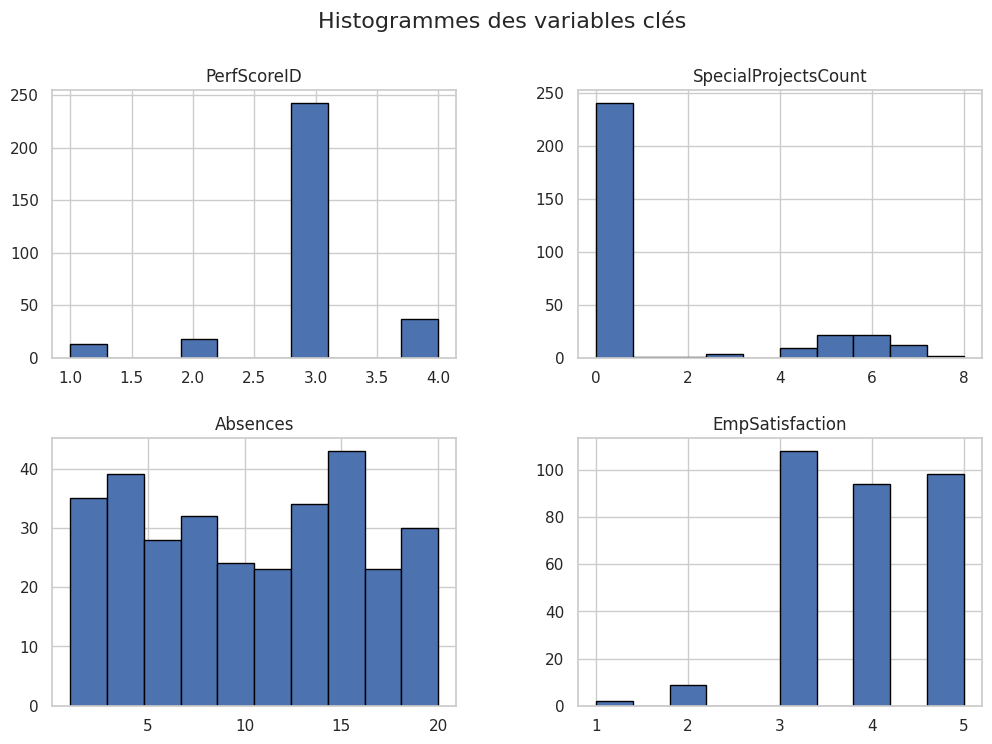

In [7]:
# Style plus propre
sns.set(style="whitegrid")

# Histogrammes
df[['PerfScoreID', 'SpecialProjectsCount', 'Absences', 'EmpSatisfaction']].hist(
    bins=10, figsize=(12, 8), edgecolor='black')
plt.suptitle("Histogrammes des variables clés", fontsize=16)
plt.show()

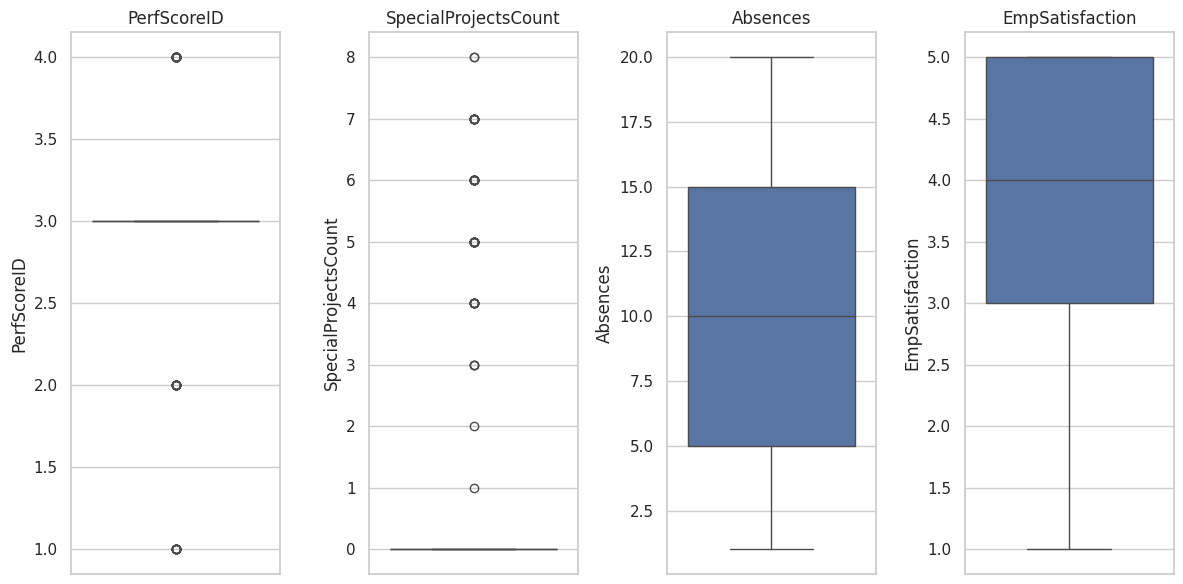

In [8]:
# Boxplots pour détecter les outliers
plt.figure(figsize=(12, 6))
for i, col in enumerate(['PerfScoreID', 'SpecialProjectsCount', 'Absences', 'EmpSatisfaction']):
    plt.subplot(1, 4, i+1)
    sns.boxplot(y=df[col])
    plt.title(col)
plt.tight_layout()
plt.show()

# 1. Histogrammes des variables clés
Ces histogrammes montrent la distribution des effectifs pour chaque variable :

- PerfScoreID
Écrasante majorité à la valeur 3 (Fully Meets) → 243 employés sur 311.

Très peu d’employés avec des scores de 1 (PIP), 2 (Needs Improvement) ou 4 (Exceeds).

Donnée très déséquilibrée → peut poser problème pour des modèles de classification.

- SpecialProjectsCount
Immense majorité à 0 projet spécial.

Quelques employés (rares) ont 4 à 8 projets → cas exceptionnels, potentiels outliers.

Distribution très asymétrique, fortement centrée sur 0.

- Absences
Répartition plus étalée et régulière entre 1 et 20 absences.

Légère concentration autour de 5, 10 et 15.

Pas de pic massif → pas de normalité stricte, mais une dispersion équilibrée.

- EmpSatisfaction
Trois pics : 3, 4 et 5, ce sont les plus fréquents.

Très peu d’employés à 1 ou 2 → peut signaler un niveau globalement satisfaisant.

# 2. Boxplots des mêmes variables
Les boxplots permettent d’identifier :

La médiane (trait central),

La dispersion (étendue interquartile),

Les outliers (points hors des moustaches).

- PerfScoreID
Score 3 = médiane, très majoritaire.

Les autres scores apparaissent comme outliers visuels à cause du déséquilibre → pas forcément "anormaux", mais moins fréquents.

- SpecialProjectsCount
Très forte concentration à 0.

À partir de 3 projets spéciaux, les individus sont considérés comme outliers → il y a une minorité de collaborateurs très sollicités.

- Absences
Boîte large → grande variabilité naturelle.

Peu ou pas d’outliers extrêmes.

Médiane = 10 absences.

- EmpSatisfaction
Valeurs basses (1–2) identifiées comme outliers négatifs.

Le reste (3–5) est bien réparti → globalement satisfaction élevée.

# Conclusion et recommandations
## Résumé :
L'analyse montre qu'il y a des écarts importants dans les performances des employés, avec une majorité dans la catégorie "Fully Meets" et quelques outliers dans les catégories "PIP" et "Exceeds".

Les employés avec peu ou pas de projets spéciaux semblent être sous-exploités, ce qui pourrait être un facteur d'amélioration.

Les absences n'ont pas un impact direct évident, mais il pourrait être utile de croiser les absences avec les performances pour détecter d’éventuelles corrélations négatives.

## Actions proposées :
Suivi des employés "PIP" pour analyser leurs performances et les raisons des absences ou des faibles scores.

Encourager la participation à des projets spéciaux pour les employés avec de faibles scores de performance.

Analyse détaillée des absences : Vérifier si les absences fréquentes sont liées à des baisses de performances et si des solutions de gestion du temps de travail peuvent être mises en place.

Modélisation prédictive : Utiliser des algorithmes pour identifier des facteurs sous-jacents influençant la performance des employés (par exemple, absences, projets, satisfaction).

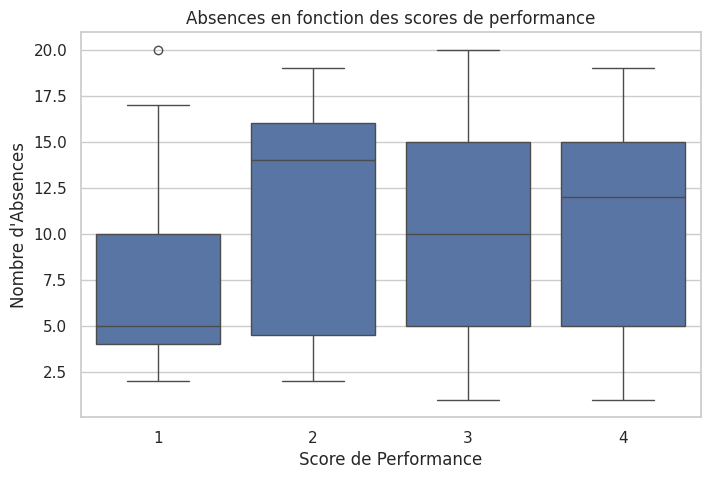

In [13]:
 # 1. Absences vs PerfScoreID (boxplot)
plt.figure(figsize=(8, 5))
sns.boxplot(x="PerfScoreID", y="Absences", data=df)
plt.title('Absences en fonction des scores de performance')
plt.xlabel('Score de Performance')
plt.ylabel('Nombre d\'Absences')
plt.show()

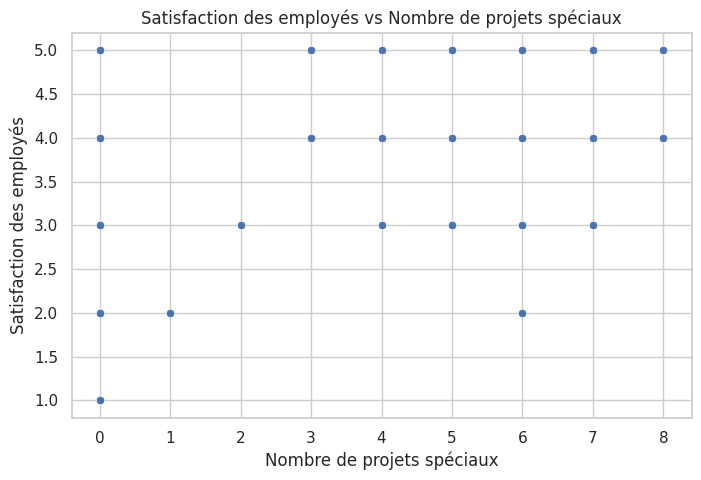

In [14]:
# 2. EmpSatisfaction vs SpecialProjectsCount (scatter plot)
plt.figure(figsize=(8, 5))
sns.scatterplot(x="SpecialProjectsCount", y="EmpSatisfaction", data=df)
plt.title('Satisfaction des employés vs Nombre de projets spéciaux')
plt.xlabel('Nombre de projets spéciaux')
plt.ylabel('Satisfaction des employés')
plt.show()

# Analyse croisée des variables
## 1️ Absences vs Score de Performance (boxplot)
Ce graphique examine si le nombre d'absences a un impact sur la performance des employés.

### Ce qu’on observe :

Les employés avec un score de performance faible (1 - PIP) ont en moyenne peu d’absences, mais un outlier élevé à 20 jours.

Ceux avec un score 2 (Needs Improvement) présentent la médiane d’absences la plus élevée (~14 absences).

Les employés avec des scores de 3 (Fully Meets) ou 4 (Exceeds) ont une médiane d’absences autour de 10–12 jours, avec une large variabilité.

### Interprétation :

L’absentéisme ne semble pas être le facteur principal de sous-performance. Certains employés très performants (score 4) sont autant, voire plus absents, que les autres.
Cependant, un grand nombre d’absences est plus fréquent chez les employés notés 2, ce qui peut indiquer un impact modéré mais pas systématique sur la performance.

## 2️ Satisfaction vs Nombre de projets spéciaux (scatter plot)
Ce graphique explore le lien entre l’implication dans des projets spéciaux et la satisfaction au travail.

### Ce qu’on observe :

Les employés avec 6 à 8 projets spéciaux ont des niveaux de satisfaction élevés (4 ou 5).

Les niveaux de satisfaction les plus faibles (1 ou 2) se trouvent principalement chez ceux qui ont 0 ou 1 projet spécial.

La satisfaction reste globalement élevée quel que soit le nombre de projets.

###Interprétation :

Il n’existe pas de relation négative entre charge de travail (nombre de projets) et satisfaction.
Au contraire, des employés très sollicités sont aussi très satisfaits, ce qui pourrait traduire une valorisation, un engagement ou un bon management.
À l’inverse, le manque d’implication dans des projets spéciaux peut être un facteur de démotivation pour certains.

##Conclusions générales (métier)
Les employés peu absents ne sont pas automatiquement les plus performants → d'autres facteurs (compétences, implication) semblent plus décisifs.

Être impliqué dans des projets spéciaux ne nuit pas à la satisfaction — au contraire, cela pourrait être un levier de motivation et d’engagement.

Il serait utile d'analyser les profils "à risque" (score de performance 2, absences élevées) pour identifier des axes d'amélioration spécifiques.

Encourager la participation à des projets spéciaux peut être une stratégie de développement RH positive, surtout pour les collaborateurs peu impliqués ou en perte de motivation.

